# Maximum Cut: a QUBO formulation


**Real-world applications:**

suppose that we have a set of different computers, each with different types of connections. Some computers have bluetooth, some have USB ports, HDMI ports, etc. We want to split our set of computers into two groups for two different projects, but it's very important that the two groups can connect to each other. The problem is sometimes the wires and connections don't work! How can we be sure that we have the best chance at remaining connected?

One way to solve this problem is with the maximum cut problem. If we think of our set of computers as a graph (a node/vertex for each computer), and draw an edge between computers that can connect to each other, we have a model of our network. If we look for a maximum cut in our graph, then we are looking for a way to split the nodes into two groups so that there are as many edges as possible between the groups. In our computer set, this means that we have two groups with as many connections as possible between the two groups. Now if one connection goes down, we have many more to use! This way we have created a more resilient network by providing many redundant connections between groups in case one connection fails.

Below we see a simple network of five nodes and three different ways to split the set of nodes into two groups. The dashed edges in each graph highlight the cut edges.

<img src="files/cut.png" alt="" style="width: 500px;"/>


# Code Overview


The answer that we are looking for is a partition of the nodes in the graph. 
We will assign a binary variable for each node, i.e. variable $x_i$ denotes whether node $i$ is in one subset (call it Subset $0$) or the other (Subset $1$).

**Objective function:** maximizing the number of cut edges

**Note that** We only want to count an edge if the endpoints are in different subsets, and so we assign a $1$ for the edge_score column in this case and a $0$ otherwise.


<img src="files/tabella.png" alt="" style="width: 200px;"/>

From this table, we can use the expression $x_i+x_j-2x_ix_j$ to calculate the edge_score column in our table. 

For the entire graph, **the objective function is:** 

<img src="files/formula 1.png" alt="" style="width: 200px;"/>

where the sum is over all edges in the graph.

To minimize an objective function, we must convert this maximization problem to a minimization problem by multiplying the expression by -1. **The final QUBO expression is the following.**

<img src="files/formula 2.png" alt="" style="width: 200px;"/>



Indeed, we have $x_{12},x_{13}, x_{24},x_{34},x_{35},x_{45}=1$

so, the QUBO is:

$min[-x_1-x_2+2x_{12}-x_1-x_3+2x_{1} x_{3}-x_2-x_4+2x_{24}-x_3-x_4+2x_{34}-x_3-x_5+2x_{35}-x_4-x_5+2x_{45}]=$

$min[-2x_1-2x_2-3x_3-3x_4-2x_5+2x_{12}+2x_{13}+2x_{24}+2x_{34}+2x_{35}+2x_{45}]$

For the graph shown above, this QUBO results in the following Q matrix. In the Q matrix (implemented as a dictionary using Ocean), we put the coefficients on the linear terms in our QUBO along the diagonal and the quadratic terms on the off-diagonal.

<img src="files/tabella2.png" alt="" style="width: 200px;"/>

In the code, we create this Q matrix as a dictionary iteratively, looping over the edges in our graph just as we see in the summation of our QUBO expression.



In [1]:
# ------ Import necessary packages ----
from collections import defaultdict

from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite
import networkx as nx

import matplotlib
matplotlib.use("agg")
from matplotlib import pyplot as plt
from IPython.display import Image, display



In [2]:
# ------- Set up our graph -------

# Create empty graph
G = nx.Graph()

# Add edges to the graph (also adds nodes)
G.add_edges_from([(1,2),(1,3),(2,4),(3,4),(3,5),(4,5)])


In [3]:
# ------- Set up our QUBO dictionary -------

# Initialize our Q matrix
Q = defaultdict(int)

# Update Q matrix for every edge in the graph
for i, j in G.edges:
    Q[(i,i)]+= -1
    Q[(j,j)]+= -1
    Q[(i,j)]+= 2
    
print(Q)

defaultdict(<class 'int'>, {(1, 1): -2, (2, 2): -2, (1, 2): 2, (3, 3): -3, (1, 3): 2, (4, 4): -3, (2, 4): 2, (3, 4): 2, (5, 5): -2, (3, 5): 2, (4, 5): 2})


# Set up QPU parameters

There are two parameters to be set by the user in this code: 

**number of reads:** 

**chain strength:**   chain_strength (float/mapping/callable, optional) – Sets the coupling strength between qubits representing variables that form a chain. Mappings should specify the required chain strength for each variable. Callables should accept the BQM and embedding and return a float or mapping. By default, chain_strength is calculated with uniform_torque_compensation().

We want each chain to contain qubits that
are all the same color, that is, either all 0 or all 1. A chain is broken if it connects qubits of
different colors. By enabling another option in the problem inspector (on the toolbar on the
left of the screen) to show broken chains in red, we can see that all of the chains are broken:

The way embedding works is as follows:

    - Each logical variable – that is, each binary variable in the original graph – is represented by a
    chain of physical qubits in the QPU.
     - We want all the physical qubits in a given chain to have the same value, all 0 or all 1, at the end
    of the annealing cycle. If they agree, then it is easy to map the qubit values back to the variable
    value in the original problem. If not, then postprocessing software (chain break fixing) is used
    to guess which is the correct assignment to the variable.
    - The qubit chains are constrained to have the same value, 0 or 1, by a single parameter, the chain
    strength. This is the weight that is assigned to the gray edges.
    - If the chain strength is not large enough, the physical qubits in the chain will not take the same
    value at the end of the annealing process, and the chain will break.
    -If the chains break, the solutions returned from the processor may be degraded and are less likely
    to be optimal.

# operational hint: 
we examine the entries in our Q matrix and choose a relatively large number to enforce chains in our embedding. For this problem, our matrix entries range from -3 to +2 and so a value of 8 is chosen for chainstrength, as suggested in the Dwave documentation https://www.dwavesys.com/media/vsufwv1d/14-1041a-a_setting_the_chain_strength.pdf
    How do we know what is a reasonable value for the chain strength? A good first estimate is to set the chain strength equal to something near the largest absolute value in the problem’s QUBO

**NOTE THAT** increasing the chain strength eliminates the broken chains and can provide a higher percentage of valid solutions to the problem. However, pay attention that as chain
strengths get larger, the individual QUBO terms, and the problem constraints, shrink to near zero. Each chain begins to
act like a separate entity, it no longer represents the original problem.


**We should try to keep chain strength within a reasonable range: large enough to avoid chain breaks, but small enough to maintain the importance of the QUBO terms.**


In [4]:
# ------- Run our QUBO on the QPU -------

chainstrength = 8
numruns = 1000

# Run the QUBO on the solver from your config file
sampler = EmbeddingComposite(DWaveSampler())
response = sampler.sample_qubo(Q,
                               chain_strength=chainstrength,
                               num_reads=numruns,
                               label='Example - Maximum Cut')


In [5]:
# ------- Print results to user -------
print('-' * 60)
print('{:>15s}{:>15s}{:^15s}{:^15s}'.format('Set 0','Set 1','Energy','Cut Size'))
print('-' * 60)
for sample, E in response.data(fields=['sample','energy']):
    S0 = [k for k,v in sample.items() if v == 0]
    S1 = [k for k,v in sample.items() if v == 1]
    print('{:>15s}{:>15s}{:^15s}{:^15s}'.format(str(S0),str(S1),str(E),str(int(-1*E))))

# ------- Display results to user -------
# Grab best result
# Note: "best" result is the result with the lowest energy
# Note2: the look up table (lut) is a dictionary, where the key is the node index
#   and the value is the set label. For example, lut[5] = 1, indicates that
#   node 5 is in set 1 (S1).
lut = response.first.sample #print best energy 

------------------------------------------------------------
          Set 0          Set 1    Energy        Cut Size    
------------------------------------------------------------
         [1, 4]      [2, 3, 5]     -5.0             5       
         [2, 3]      [1, 4, 5]     -5.0             5       
      [1, 4, 5]         [2, 3]     -5.0             5       
      [2, 3, 5]         [1, 4]     -5.0             5       


In [6]:
# Interpret best result in terms of nodes and edges
S0 = [node for node in G.nodes if not lut[node]]
S1 = [node for node in G.nodes if lut[node]]
cut_edges = [(u, v) for u, v in G.edges if lut[u]!=lut[v]]
uncut_edges = [(u, v) for u, v in G.edges if lut[u]==lut[v]]

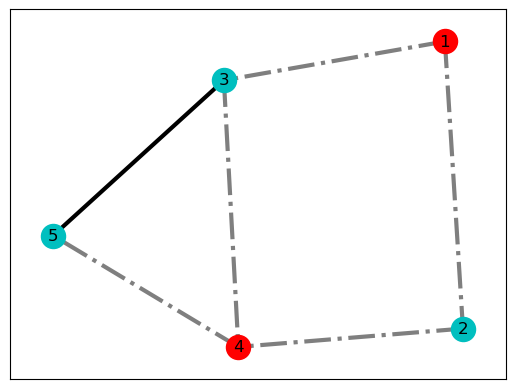

In [7]:
# Display best result
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, nodelist=S0, node_color='r')
nx.draw_networkx_nodes(G, pos, nodelist=S1, node_color='c')
nx.draw_networkx_edges(G, pos, edgelist=cut_edges, style='dashdot', alpha=0.5, width=3)
nx.draw_networkx_edges(G, pos, edgelist=uncut_edges, style='solid', width=3)
nx.draw_networkx_labels(G, pos)

filename = "maxcut_plot.png"
plt.savefig(filename, bbox_inches='tight')
#print("\nYour plot is saved to {}".format(filename))

display(Image(filename))

Example from Dwave Leap. References: Dunning, Iain, Swati Gupta, and John Silberholz. "What works best when? A systematic evaluation of heuristics for Max-Cut and QUBO." INFORMS Journal on Computing 30.3 (2018): 608-624.